# Temperature Profile Classification - 2 Class system
GMM classification of Southern Ocean Argo float temperature profile data. This notebook looks at automatic generation for PCA N values, with 2 classes.<br><br>
### Dask import

<br>

### Choices for data

In [1]:
#File imports
maskName = "OceanMaskESM2"
dataFileName = "GMMSampleData3AL.npy"
sampleFileName = "GMMSampleTimeGeo3.npy"
scalerName = "GMMScaler3AL.bin"
modelName = "GMM3AL2Class"

#Data definitions
lastESMDecade = slice('2005-01','2014-12')

#Custom GMM variables
createModel = True #if true creates a new model in this notepad. if false the model in modelname is imported
saveModel = True #if true saves a model under model name. To work createModel has to be enabled.
pcaThreshold = 0.98
pcaNControl = 0 #set to int value to select, otherwise pcaThreshold is used to automatically assign value
firstBicLoopControl = 10 #number of times bic value is calculated for each number of classes
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [3]:
sampleDataLabelled = np.load(dataFileName)
sampleDepthAxis = sampleDataLabelled[0]
sampleData = sampleDataLabelled[1:]

sampleTimeGeo = np.load(sampleFileName, allow_pickle=True)
print("Sample data loaded into sampleData.\nSample time geo data loaded into sampleTimeGeo.")

Sample data loaded into sampleData.
Sample time geo data loaded into sampleTimeGeo.


<br>
<b>Loading ocean Mask</b>

In [4]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Combining sample data and sample time/geo data</b>

In [5]:
metaData = {"Lat":sampleTimeGeo[0], "Lon":sampleTimeGeo[1], "Time":sampleTimeGeo[2]}
sampleMetaDF = pd.DataFrame(metaData, columns=["Lat", "Lon", "Time"])
sampleDataDF = pd.DataFrame(sampleData, columns=sampleDepthAxis)
sampleDF = pd.concat([sampleMetaDF,sampleDataDF], axis=1)
print("SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.")

SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
<li>loadModel - loadeds and returns GMM model named in input.
</ul>

In [6]:
def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li>bicPlot - Plots BIC score array against component number.
<li>locationPlotTime - Plots locations of an input data array on a map with a colour scale for time.
<li>tempPointPlot - Plots the temperature profile of a single point against depth.
<li>tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [7]:
def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    bicArrayMin = np.min(bicArray)
    bicRange = bicArrayMax-bicArrayMin
    if bicRange == 0:
        bicRange = 20 #provides border 1 if all bic values are identical
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([bicArrayMin-0.05*bicRange, bicArrayMax+0.05*bicRange])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)
    
    
def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")  
    
    
def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
def locationPlotUncertainty(dataArray, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c =  dataArray["classUncertainty"], cmap='Blues')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Uncertainty in Sample Locations ("+str(len(metaDataArray[0]))+")") 
    
def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()

    
def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0])[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)'''

print("Plotting functions defined.")

Plotting functions defined.


<br>

### Scaling
<b>Scaling Implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [8]:
scalerLoad = load(scalerName)
sampleDataScaled = scalerLoad.transform(sampleData)
print("Scaling of sampleData complete, stored in sampleDataScaled.")

Scaling of sampleData complete, stored in sampleDataScaled.


/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

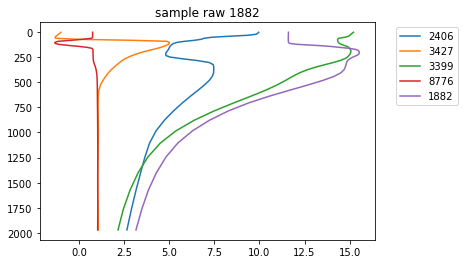

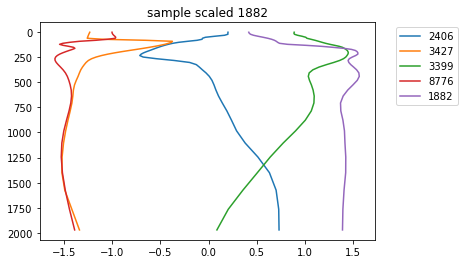

In [9]:
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(10000)
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*2*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*2*i+1)

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [10]:
for i in range(1,8):
    pca = PCA(n_components=i) #initialising PCA 
    pca.fit(sampleDataScaled) #fitting model to data
    totalVarianceExplained = np.sum(pca.explained_variance_ratio_)
    print("For "+str(i)+" PCA components, "+str(totalVarianceExplained)+" is explained.") #total variance explained by model.
    if not(pcaNControl) and (totalVarianceExplained > pcaThreshold):
        pcaNControl = i
        print("Threshold of "+str(pcaThreshold)+" exceeded, pcaNControl assigned a value of "+str(i))
print("\nAssigned value of pcaNcontrol = "+str(pcaNControl))

For 1 PCA components, 0.9260884852934786 is explained.
For 2 PCA components, 0.9590096831799618 is explained.
For 3 PCA components, 0.9753445589951475 is explained.
For 4 PCA components, 0.9845374266645445 is explained.
Threshold of 0.98 exceeded, pcaNControl assigned a value of 4
For 5 PCA components, 0.9908972095673264 is explained.
For 6 PCA components, 0.9946821501169154 is explained.
For 7 PCA components, 0.9967613032492358 is explained.

Assigned value of pcaNcontrol = 4


In [11]:
pca = PCA(n_components=pcaNControl) #initialising PCA 
pca.fit(sampleDataScaled) #fitting model to data
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### Model generation/BIC score calculation
To identify the best fitting models a BIC score metric is used, with a lower BIC score indicating a better model. BIC scores for each number of classes will differ based on starting values used in the modelling, so repeated runs of the BIC scoring helps to provide a more overall score for each number of classes.

The number of iterations for each quantity of classes can be controlled by modifying the bicLoopControl variable at the top of the notepad in [Choices for data](#Choices-for-data).

In [12]:
if createModel:
    bicMin = np.infty
    bicComponentMin = 2
    bicRaw = np.empty(shape=(0))

    bicCurrentArray = np.empty(shape=(0))
    for i in range(firstBicLoopControl):    #Number of iterations for each number of components
        GMModel = mixture.GaussianMixture(n_components = 2, covariance_type = cvType) #Run modelling
        GMModel.fit(sampleDataScaledPCA)

        bicCurrent = GMModel.bic(sampleDataScaledPCA)
        bicCurrentArray = np.append(bicCurrentArray, bicCurrent)
        if bicCurrent < bicMin:   #if latest BIC score is lowest, update and save model
            bicMin = bicCurrent
            bicComponentMin = 2
            bestGMModel = GMModel
            GMMRunId = i

    bicRaw = np.append(bicRaw, bicCurrentArray)  
    componentNo = bestGMModel.n_components

    if componentNo != bicComponentMin:
        print("Warning, error with assigning optimum GMM. The model was unable to be saved.")
    elif saveModel:
        saveModel(bestGMModel, modelName)
        print("Best GMM from training saved to "+modelName+".")
        
    print("Modelling and scoring complete. The lowest bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+" from run "+str(GMMRunId)+".")
    print("BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.")
else:
    bestGMModel = loadModel(modelName)
    bicMin = bestGMModel.bic(sampleDataScaledPCA)
    bicComponentMin = bestGMModel.n_components
    print("Model "+modelName+" loaded. The bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")

Best GMM from training saved to GMM3AL2Class.
Modelling and scoring complete. The lowest bicScore was 155573.22 for 2 from run 1.
BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.


<br>

### BIC score calculations
The average and minimum BIC scores for each number of components are calculated and stored in the corresponding arrays.

In [13]:
if createModel:
    bicAvg = np.infty
    bicAvg = np.mean(bicRaw)
    print("BIC score sorting finished. Lowest scores for each component value stored in bicMin, with average BIC scores stored in bicAvg.")
else:
    print("Imported model "+modelName+" in use. No calculations necessary.")

BIC score sorting finished. Lowest scores for each component value stored in bicMin, with average BIC scores stored in bicAvg.


<br>

### BIC score plotting
Plotting the BIC scores from the modelling. The minimum BIC score indicates the ideal number of classes to be used in the model.

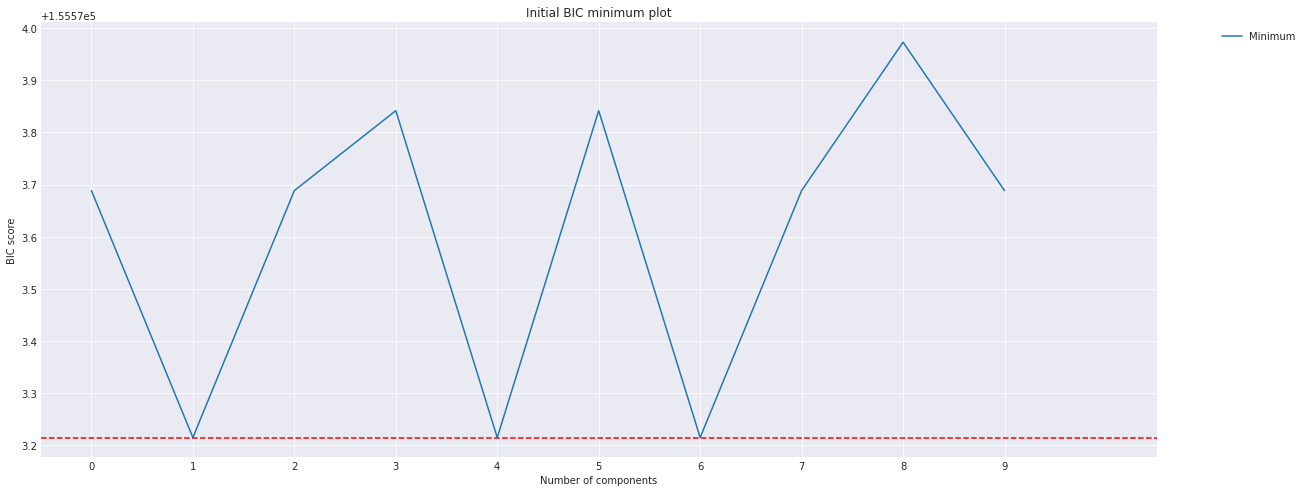

Component number with minimum BIC score: 2 with a score of 155573.2152231559 from run 1.


In [14]:
if createModel:
    bicPlot(bicRaw, 0, firstBicLoopControl, 1, "Initial BIC minimum plot", "Minimum", 1)
    plt.axhline(bicMin, color = "Red", ls="--")

    plt.show()
    print("Component number with minimum BIC score: "+str(componentNo)+" with a score of "+str(bicMin)+" from run "+str(GMMRunId)+".")
else:
    print("Imported model "+modelName+" in use. Model BIC score for training data: "+str(bicMin)+".")

<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [15]:
labels = bestGMModel.predict(sampleDataScaledPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)
classUncertainty = 2 - 2*maxPosteriorProbs

try:
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
sampleDF.insert(5, "classuncertainty", classUncertainty, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

Labels identified for model (2 components) and added to sampleDF with associated probability.


<br>

### Calculating properties of profiles based on class assignment

In [16]:
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).


<br>

### Sort the labels based on mean near-surface temperatures

In [17]:
surfaceMeans = sampleDFMeans[sampleDepthAxis[0]].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))

try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.


<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [18]:
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print(" Number of samples in each group calculated and stored in profileCount.")

sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).
 Number of samples in each group calculated and stored in profileCount.


<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [19]:
print(sampleDFSortMeans[sampleDataDF.columns[0]])

labelSorted
0     0.979058
1    13.449980
Name: 5.0, dtype: float64


<br>

### Plotting the means and standard deviations of the classes by profile

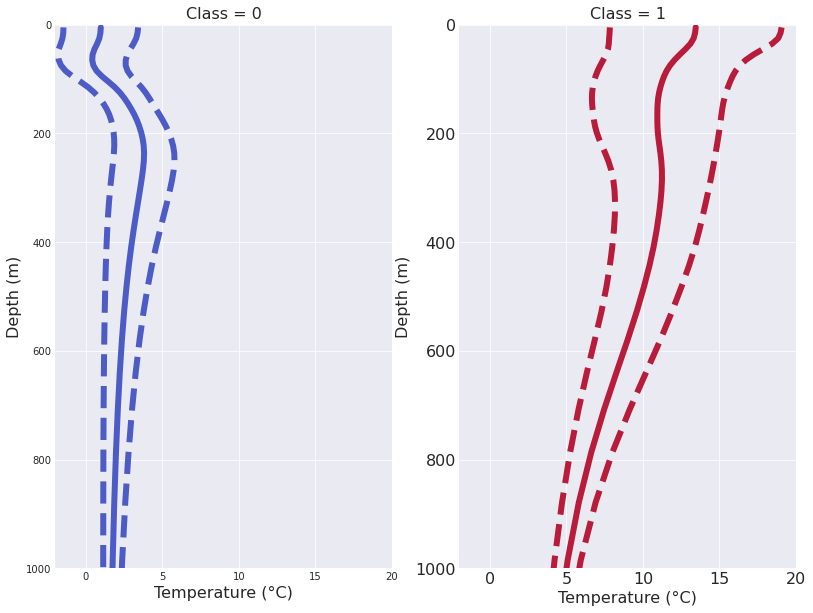

In [20]:
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

In [21]:
sampleLabelData = np.array(sampleDF["labelSorted"])
sampleMetaData = np.append(sampleTimeGeo, [sampleLabelData], axis = 0)
print("Sorted label added to sampleMetaData")

Sorted label added to sampleMetaData


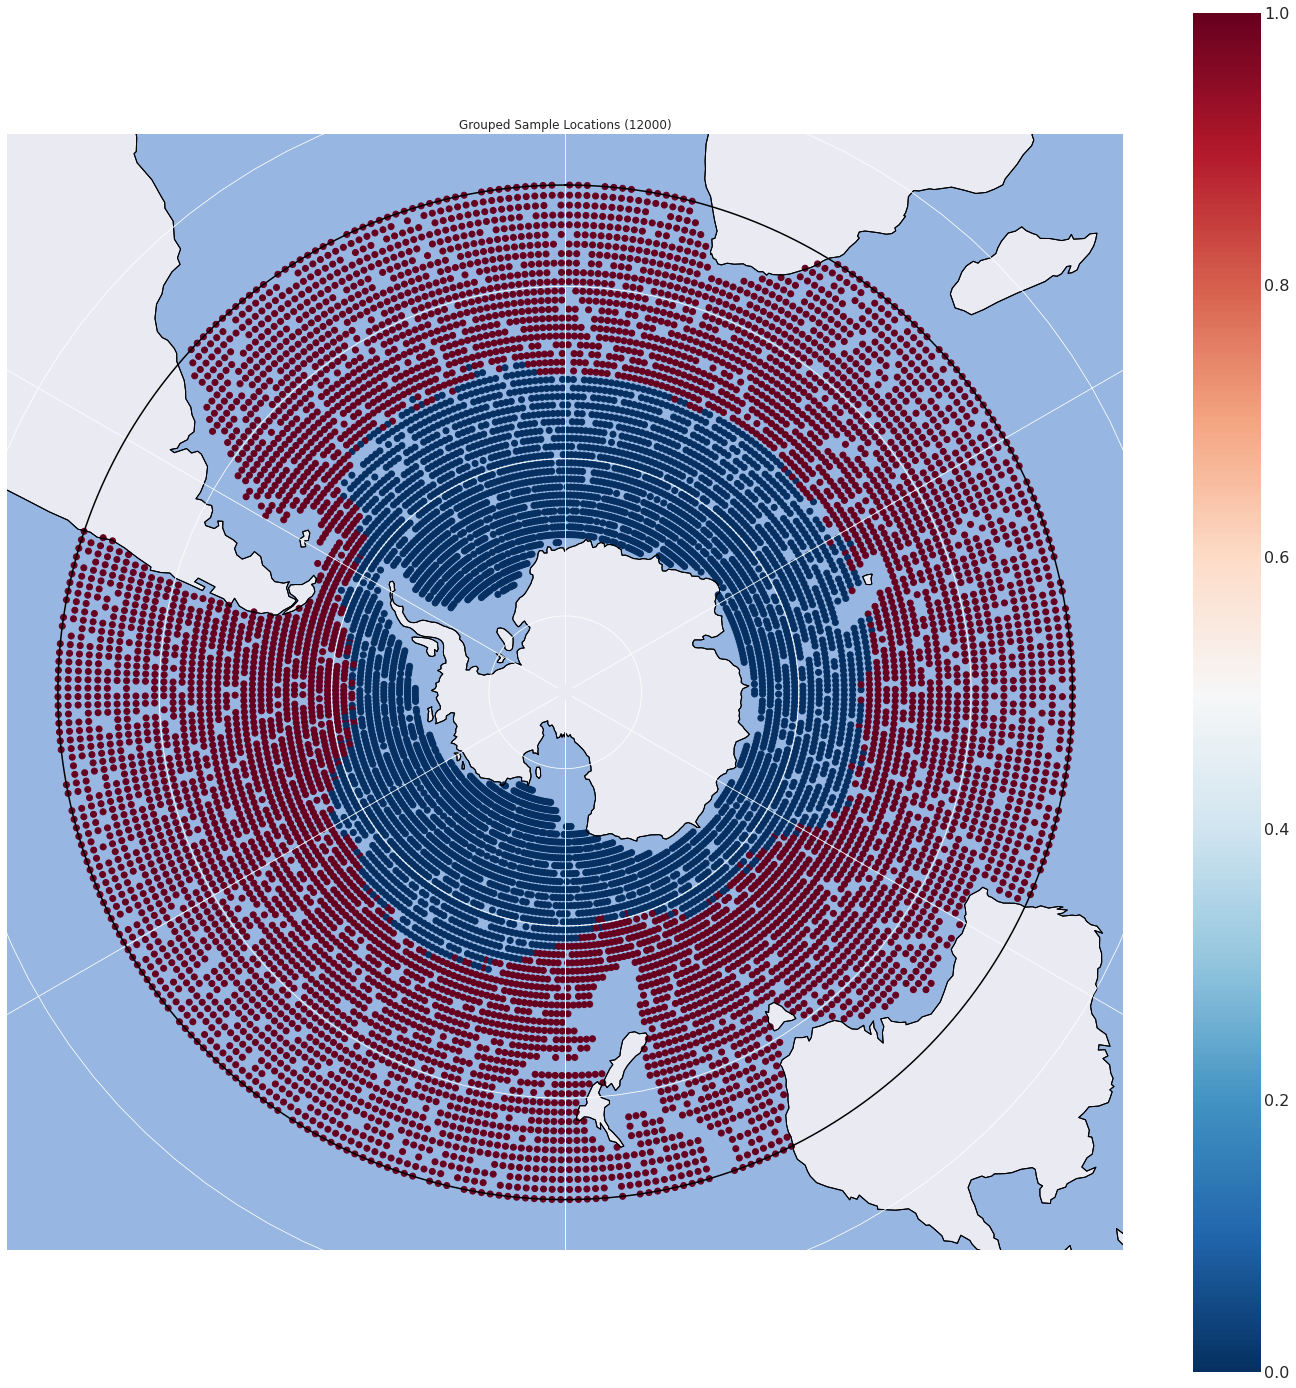

In [22]:
locationPlotGroup(sampleMetaData, (25,25), 1)